# Сбор данных из папок

<b>Данные</b> имеют следующую структуру:

- записываются для каждого пользователя, совершившего покупки, каждый день
- для каждой даты есть своя папка, внутри неё – папки для каждого пользователя
- внутри каждой папки есть файл data.csv, где и хранятся данные

Схематично выглядит так:
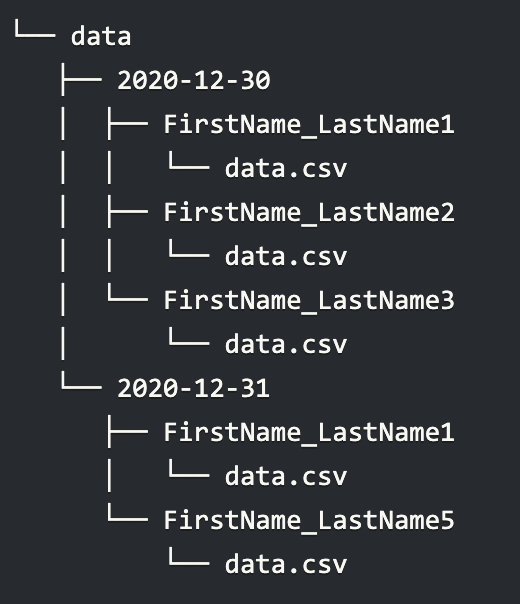

<b>Задачи</b>:
1. Собрать все данные из папки data в один датафрэйм, имеющий следующие столбцы: колонки из самих файлов (product_id, quantity), а также имя пользователя (name) и дата этих покупок (date) - соответствует названию папки, где лежит папка с пользователем.
2. Выяснить, какой пользователь купил больше всего товаров.
3. Найти топ-10 товаров по числу проданных единиц за всё время и построить барплот. Сколько было продано единиц товара с product_id==56?
4. Визуализировать продажи по дням.
5. Сколько пользователей приобрели какой-либо товар повторно (более 1 раза)? Повтором будем считать покупку товара с одинаковым product_id, совершенную в разные дни.

## Сбор данных в один датафрейм

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# путь до нужной папки с датами
path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-laschevskaja/shared/homeworks/python_ds_miniprojects/4/data/'

In [3]:
# список дат
dates = os.listdir('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-laschevskaja/shared/homeworks/python_ds_miniprojects/4/data/')

In [4]:
dates

['2020-12-05',
 '2020-12-08',
 '2020-12-09',
 '2020-12-04',
 '2020-12-06',
 '2020-12-03',
 '2020-12-07']

In [5]:
# создаем пустой датафрейм с нужными колонками
df = pd.DataFrame(columns=['product_id', 'quantity', 'name', 'date'])

In [6]:
for date in dates: # для каждой даты из списка дат
    path_date = path + date # получаем путь до дат
    list_users = os.listdir(path_date) # список юзеров по датам
    
    for user in list_users: # для каждого юзера из списка юзеров
        path_users = path_date + '/' + user # получаем путь до юзера
        list_file_name = os.listdir(path_users) # список названий файлов
        path_file = path_users + '/' + list_file_name[0] # получаем путь до файла
        temp_df = pd.read_csv(path_file, index_col=0) # читаем файлы без пустой колонки
        temp_df['name'] = user # заполняем столбец name именем юзера
        temp_df['date'] = date # заполняем дату датой
        df = df.append(temp_df) # объединяем все файлы в один

In [7]:
# сбросили индексы в датафрейме
df = df.reset_index(drop=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  161 non-null    object
 1   quantity    161 non-null    object
 2   name        161 non-null    object
 3   date        161 non-null    object
dtypes: object(4)
memory usage: 5.2+ KB


In [9]:
df.head(10)

,product_id,quantity,name,date
0,27,4,Petr_Ivanov,2020-12-05
1,89,1,Petr_Ivanov,2020-12-05
2,33,2,Petr_Ivanov,2020-12-05
3,8,3,Petr_Ivanov,2020-12-05
4,16,1,Petr_Ivanov,2020-12-05
5,55,3,Petr_Smirnov,2020-12-05
6,49,3,Petr_Smirnov,2020-12-05
7,22,5,Petr_Smirnov,2020-12-05
8,83,4,Petr_Smirnov,2020-12-05
9,66,2,Rostislav_Smirnov,2020-12-05


In [10]:
# количество всех купленных товаров всеми пользователями
df.quantity.sum()

480

## Аналитические задачи

1. Выясните, какой пользователь купил больше всего товаров.

In [11]:
df.groupby('name', as_index=False)\
    .agg({'quantity': 'sum'})\
    .sort_values('quantity', ascending=False)\
    .head()

,name,quantity
3,Alexey_Smirnov,52
13,Petr_Smirnov,52
6,Anton_Smirnov,45
10,Petr_Fedorov,34
7,Kirill_Fedorov,28


Больше всего товаров (52 штуки) купили два пользователя: Alexey_Smirnov и Petr_Smirnov.

2. Найдите топ-10 товаров по числу проданных единиц за всё время и постройте барплот (столбчатую диаграмму, sns.barplot), где:

по оси x – идентификаторы товаров (product_id) 

по оси y – суммарное число их покупок (сколько товаров с таким product_id было продано)

In [12]:
top_10 = df.groupby('product_id', as_index=False)\
    .agg({'quantity': 'sum'})\
    .sort_values('quantity', ascending=False)\
    .head(10)

In [13]:
top_10

,product_id,quantity
22,27,20
42,56,18
21,24,15
51,74,15
32,41,14
27,34,13
66,94,13
46,66,13
65,92,12
38,50,12


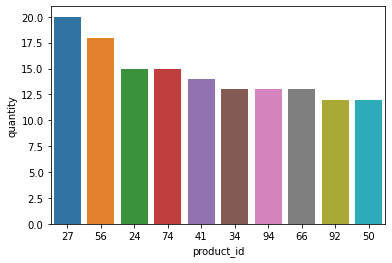

In [14]:
# сортируем по кол-во заказов
sns.barplot(x='product_id', y='quantity', data=top_10, \
            order=top_10.sort_values('quantity', ascending=False).product_id);

3. Сколько было продано единиц товара с product_id равным 56?

In [15]:
df.query('product_id == 56')['quantity'].sum()

18

4. Посмотрим на продажи по дням. Построим график, только теперь по оси x будут дни, по которым у нас есть данные (date).

In [16]:
st_days = df.groupby('date', as_index=False)\
    .agg({'quantity': 'sum'})\
    .sort_values('date')

In [17]:
st_days

,date,quantity
0,2020-12-03,60
1,2020-12-04,113
2,2020-12-05,61
3,2020-12-06,15
4,2020-12-07,94
5,2020-12-08,68
6,2020-12-09,69


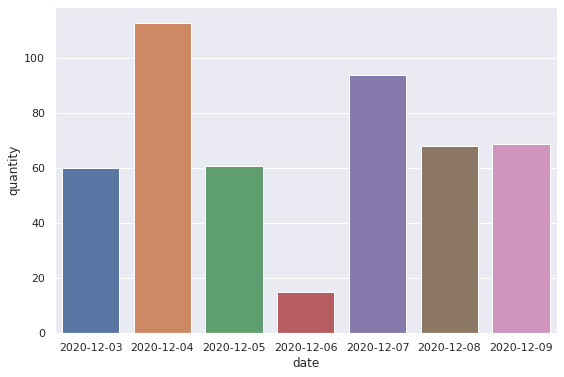

In [18]:
# увеличим размер графика
sns.set(rc={'figure.figsize':(9,6)})
# сортируем по дате
sns.barplot(x='date', y='quantity', data=st_days, \
            order=st_days.sort_values('date').date);

Выводы по графику:
- Меньше всего товаров было приобретено 6 декабря.
- 4 декабря было куплено почти в два раза больше товаров, чем в предыдущий день.
- Максимальное число товаров было продано 4 декабря.
- 8 и 9 декабря было продано примерно одинаковое число товаров.

5. Сколько пользователей приобрели какой-либо товар повторно (более 1 раза)? Повтором будем считать покупку товара с одинаковым product_id, совершенную в разные дни.

In [19]:
# удалили дубликаты по продукту/юзеру/дате
test_df = df.drop_duplicates(subset=['product_id', 'name', 'date'])

In [20]:
# сгруппировали по юзеру и продукту, посчитали кол-во дней, выбрали больше 1 дня
test_df.groupby(['name', 'product_id'], as_index=False)\
    .agg({'date': 'count'})\
    .query('date > 1')

,name,product_id,date
37,Anton_Ivanov,15,2
92,Petr_Fedorov,94,2


Два пользователя Anton_Ivanov и Petr_Fedorov приобрели товары повторно в разные дни.

## Выводы

В ходе данного проекта:
- собрали данные из разных папок и файлов в один датасет
- выяснили, какой пользователь купил больше всего товаров
- нашли топ-10 товаров по числу проданных единиц за всё время
- посчитали, сколько было продано единиц товара с product_id==56
- визуализировали продажи по дням
- узнали, сколько пользователей приобрели какой-либо товар повторно в разные дни